In [29]:
import numpy as np # linear algebra
import struct
from array import array
import os

In [30]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
    

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  
    

In [31]:
path  = os.getcwd()+'/archive'
#training images and labels
training_images_filepath = os.path.join(path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = os.path.join(path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')

#testing images and labels
testing_images_filepath = os.path.join(path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
testing_labels_filepath = os.path.join(path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath,
                                      testing_images_filepath, testing_labels_filepath)

(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [32]:
'''
import matplotlib.pyplot as plt
%matplotlib inline

print(len(x_train))

all = np.array([])
h = 10
w = 10
fig = plt.figure(figsize=(8, 8))
for i in range(h*w):
    ax = fig.add_subplot(h, w, i+1)
    ax.imshow(np.array(x_train[i]).reshape((28, 28)))
    ax.axis("off")
    #ax.set_title(str(y_train[i]))
'''

'\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\nprint(len(x_train))\n\nall = np.array([])\nh = 10\nw = 10\nfig = plt.figure(figsize=(8, 8))\nfor i in range(h*w):\n    ax = fig.add_subplot(h, w, i+1)\n    ax.imshow(np.array(x_train[i]).reshape((28, 28)))\n    ax.axis("off")\n    #ax.set_title(str(y_train[i]))\n'

In [33]:
import torch
import torch.nn as nn

class mnistNet(nn.Module):
    def __init__(self):
        super(mnistNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

In [34]:
model = mnistNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()


x_train = torch.stack([torch.Tensor([i]) for i in x_train])
y_train = torch.stack([torch.Tensor([i]) for i in y_train])

x_test = torch.stack([torch.Tensor([i]) for i in x_test])
y_test = torch.stack([torch.Tensor([i]) for i in y_test])

from tqdm import tqdm as tq

print("start training!")

batch_size = 32
losses = []
for i in tq(range(1000)):
    sample = torch.randint(0, len(x_train), size=(batch_size,))
    x_train_batch = x_train[sample]
    y_train_batch = y_train[sample].reshape(batch_size).long()
    optimizer.zero_grad()
    output = model(x_train_batch)
    loss_val = loss(output, y_train_batch)
    losses.append(loss_val.item())
    loss_val.backward()
    optimizer.step()
    #if i % 100 == 0:
    #    print('Epoch: {}, Loss: {:.4f}'.format(i, loss_val.item()))

print("finish training!")

start training!


100%|██████████| 1000/1000 [17:31<00:00,  1.05s/it]

finish training!


In [35]:
error = 0
for i in tq(range(len(x_test))):
    predict = model(x_test[i].reshape(1, 1, 28, 28))
    truth = int(y_test[i])
    predict = int(torch.argmax(predict))
    error += (predict != truth)

print("error rate: ", error/len(x_test))
    

100%|██████████| 10000/10000 [00:20<00:00, 498.67it/s]

error rate:  0.0908


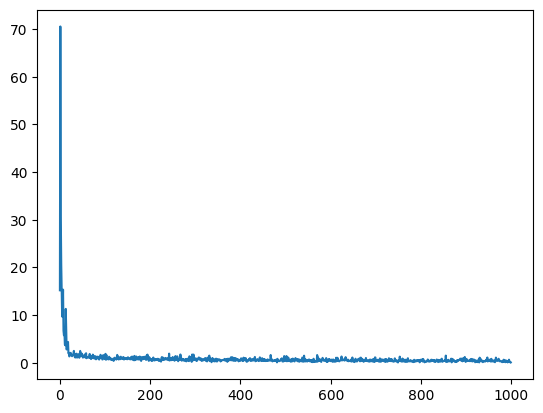

In [36]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()